In [1]:
from array import array
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
from matplotlib.ticker import NullFormatter

#This line is important. On this server I don't know if we have the ability to output plots. This is a solution.

%matplotlib inline

#Importing root_pandas and root_numpy.

import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import root_pandas as rpd
import ROOT
from root_pandas import read_root

Welcome to ROOTaaS 6.06/06


In [2]:
def getData(inputFiles):
    
    scalarColumns = []
    scalarColumns.append('ue_estimate_its_const')

    arrayColumns = []
    arrayColumns.append('cluster_pt')
    arrayColumns.append('cluster_eta')
    arrayColumns.append('cluster_ncell')
    arrayColumns.append('cluster_e')
    arrayColumns.append('cluster_e_cross')
    arrayColumns.append('cluster_tof')
    arrayColumns.append('cluster_nlocal_maxima')
    arrayColumns.append('cluster_iso_its_04')
    arrayColumns.append('cluster_iso_its_04_ue')
    arrayColumns.append('cluster_Lambda')

    columns = scalarColumns + arrayColumns

    dfs = []
    for inputFile in inputFiles:
        start = time.time()
        filename = os.path.basename(inputFile)
        dataframe = rpd.read_root(inputFile, columns=columns, flatten=arrayColumns)
        end = time.time()
        print 'Processed {0} in {1} seconds'.format(filename, end - start)
        dfs.append(dataframe)

    return pd.concat(dfs).drop_duplicates().reset_index(drop=True)

In [3]:
pPbFiles = ['Skimmed_13def_ptmin12.0_Nevent_1416399.root']
pPbHist_04 = getData(pPbFiles)

ppFiles = ['Skimmed_17q_wSDD_ptmin12.0_Nevent_937949.root']
ppHist_04 = getData(ppFiles)

Processed Skimmed_13def_ptmin12.0_Nevent_1416399.root in 44.5818538666 seconds
Processed Skimmed_17q_wSDD_ptmin12.0_Nevent_937949.root in 19.7859520912 seconds


In [4]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [5]:
def applyCuts(fullDataframe,name='default'):  
    
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e',inplace=True)
    fullDataframe.eval('cluster_iso_its_04_sub = cluster_iso_its_04 + cluster_iso_its_04_ue - ue_estimate_its_const*0.4*0.4*3.1416',inplace=True)
    
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'cluster_pt > 12.0',            '12 GeV < pt:')
    dataframe = applyCut(dataframe, 'abs(cluster_eta) < 0.67',      '|eta| < 0.67:')
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e > 0.03', 'ecross/e > 0.03:')
    dataframe = applyCut(dataframe, 'cluster_ncell > 2',            'number of cells > 2')
    dataframe = applyCut(dataframe, 'abs(cluster_tof) < 20',        '|tof| < 20:')
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima < 3',    'maxima < 3:')
    dataframe = applyCut(dataframe, 'cluster_iso_its_04_sub < 1.5', 'Number with ISO pt in its < 1.5 GeV:')
    dataframe = applyCut(dataframe, 'cluster_Lambda > 0.4',         'Lambda > 0.4:')
    
    return dataframe

In [6]:
print 'p-Pb Data'
pPbHists_04 = applyCuts(pPbHist_04)
print '\n'
print 'pp Data'
ppHists_04  = applyCuts(ppHist_04)

p-Pb Data
12 GeV < pt: 727953  fraction kept: 21.2
|eta| < 0.67: 727617  fraction kept: 100.0
ecross/e > 0.03: 625431  fraction kept: 86.0
number of cells > 2 624977  fraction kept: 99.9
|tof| < 20: 620964  fraction kept: 99.4
maxima < 3: 435925  fraction kept: 70.2
Number with ISO pt in its < 1.5 GeV: 134513  fraction kept: 30.9
Lambda > 0.4: 84480  fraction kept: 62.8


pp Data
12 GeV < pt: 415247  fraction kept: 22.2
|eta| < 0.67: 415176  fraction kept: 100.0
ecross/e > 0.03: 347164  fraction kept: 83.6
number of cells > 2 343473  fraction kept: 98.9
|tof| < 20: 253378  fraction kept: 73.8
maxima < 3: 175814  fraction kept: 69.4
Number with ISO pt in its < 1.5 GeV: 60085  fraction kept: 34.2
Lambda > 0.4: 38172  fraction kept: 63.5


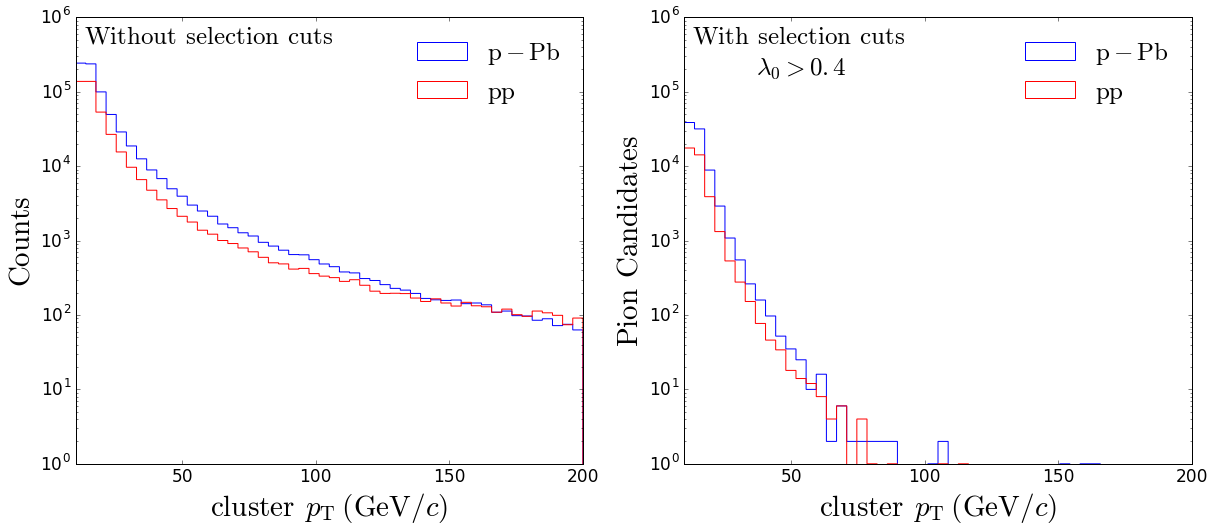

In [7]:
###Analyses of how the cuts impact higher pT clusters###

fig = plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.hist(pPbHist_04['cluster_pt'],bins =50,range=(10,200),histtype='step',label=r'$\mathrm{p-Pb}$');
plt.hist(ppHist_04['cluster_pt'],bins =50,range=(10,200),histtype='step',color='r',label=r'$\mathrm{pp}$');
plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \:(\mathrm{GeV}/c)$',fontsize = 29)
plt.ylabel(r'$\mathrm{Counts}$',fontsize = 29)
plt.xticks(fontsize = 17)
plt.xlim((10,200))
plt.yticks(fontsize = 17)
plt.yscale('log')
plt.ylim((1,1000000))

plt.legend(frameon=False,fontsize=25)

plt.text(13,450000,r'$\mathrm{Without \:\: selection \:\: cuts}$',fontsize=25)

# plt.subplot(2,2,2)
# plt.hist(pPbHist_04['cluster_pt'],bins =50,range=(80,200),histtype='step',label=r'$\mathrm{p-Pb}$');
# plt.hist(ppHist_04['cluster_pt'],bins =50,range=(80,200),histtype='step',color='r',label=r'$\mathrm{pp}$');
# plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \:(\mathrm{GeV}/c)$',fontsize = 29)
# plt.ylabel(r'$\mathrm{Pion \:\:Candidates}$',fontsize = 29)
# plt.xticks(fontsize = 17)
# plt.yticks(fontsize = 17)
# plt.yscale('log')
# plt.ylim((0.1,10000))

# plt.legend(frameon=False,fontsize=25)

# plt.text(84,5000,r'$\mathrm{Without \:\: selection \:\: cuts}$',fontsize=25)

plt.subplot(1,2,2)
plt.hist(pPbHists_04['cluster_pt'],bins =50,range=(10,200),histtype='step',label=r'$\mathrm{p-Pb}$');
plt.hist(ppHists_04['cluster_pt'],bins =50,range=(10,200),histtype='step',color='r',label=r'$\mathrm{pp}$');
plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \:(\mathrm{GeV}/c)$',fontsize = 29)
plt.ylabel(r'$\mathrm{Pion \:\:Candidates}$',fontsize = 29)
plt.xticks(fontsize = 17)
plt.xlim((10,200))
plt.yticks(fontsize = 17)
plt.yscale('log')
plt.ylim((1,1000000))

plt.legend(frameon=False,fontsize=25)

plt.text(13,450000,r'$\mathrm{With \:\: selection \:\: cuts}$',fontsize=25)

plt.text(37,170000,r'$\lambda_{0} > 0.4$',fontsize=25)

# plt.subplot(2,2,4)
# plt.hist(pPbHists_04['cluster_pt'],bins =50,range=(80,200),histtype='step',label=r'$\mathrm{p-Pb}$');
# plt.hist(ppHists_04['cluster_pt'],bins =50,range=(80,200),histtype='step',color='r',label=r'$\mathrm{pp}$');
# plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \:(\mathrm{GeV}/c)$',fontsize = 29)
# plt.ylabel(r'$\mathrm{Pion \:\:Candidates}$',fontsize = 29)
# plt.xticks(fontsize = 17)
# plt.yticks(fontsize = 17)
# plt.yscale('log')
# plt.ylim((0.1,10000))

# plt.legend(frameon=False,fontsize=25)

# plt.text(84,5000,r'$\mathrm{With \:\: selection \:\: cuts}$',fontsize=25)

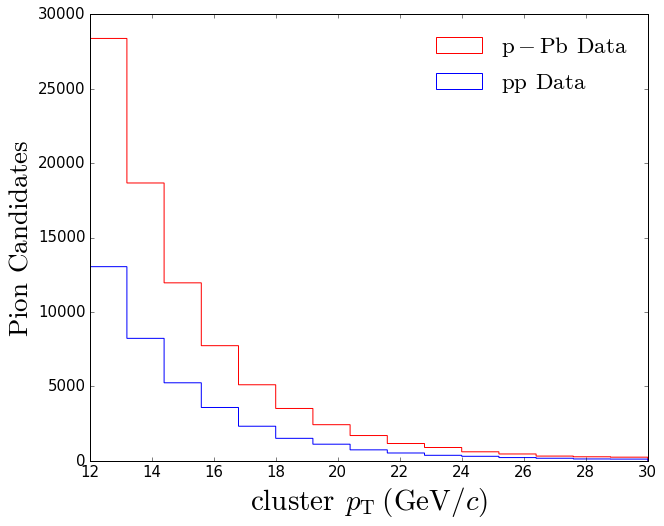

In [8]:
###Compare the pion candidates of pp to p-Pb data as a function of pT###

fig = plt.figure(figsize=(10,8))

plt.hist(pPbHists_04["cluster_pt"],bins=15,color='r',range=(12,30),label = r'$\mathrm{p-Pb \:\: Data}$',histtype='step',stacked=True,fill=False)
plt.hist(ppHists_04["cluster_pt"],bins=15,color='b',range=(12,30),label = r'$\mathrm{pp \:\: Data}$',histtype='step',stacked=True,fill=False)

plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \:(\mathrm{GeV}/c)$',fontsize = 29)
plt.xticks(fontsize = 15)
plt.ylabel(r'$\mathrm{Pion \:\:Candidates}$',fontsize = 27)
plt.yticks(fontsize = 15)
plt.legend(prop={'size':23},frameon=False)

In [9]:
#####Split it into different pt bins#####

###p-Pb###

pPbHists_04_pt_13  = pPbHists_04.query('cluster_pt > 12 and  cluster_pt < 14')
pPbHists_04_pt_15  = pPbHists_04.query('cluster_pt > 14 and  cluster_pt < 16')
pPbHists_04_pt_17  = pPbHists_04.query('cluster_pt > 16 and  cluster_pt < 18')

pPbHists_04_pt_20  = pPbHists_04.query('cluster_pt > 18 and  cluster_pt < 22')
pPbHists_04_pt_24  = pPbHists_04.query('cluster_pt > 22 and  cluster_pt < 26')
pPbHists_04_pt_28  = pPbHists_04.query('cluster_pt > 26 and  cluster_pt < 30')

pPbHists_04_pt_325  = pPbHists_04.query('cluster_pt > 30 and  cluster_pt < 35')
pPbHists_04_pt_375  = pPbHists_04.query('cluster_pt > 35 and  cluster_pt < 40')
pPbHists_04_pt_425  = pPbHists_04.query('cluster_pt > 40 and  cluster_pt < 45')

pPbHists_04_pt_50  = pPbHists_04.query('cluster_pt > 45 and  cluster_pt < 55')
pPbHists_04_pt_60  = pPbHists_04.query('cluster_pt > 55 and  cluster_pt < 65')
pPbHists_04_pt_70  = pPbHists_04.query('cluster_pt > 65 and  cluster_pt < 75')
pPbHists_04_pt_80  = pPbHists_04.query('cluster_pt > 75 and  cluster_pt < 85')
pPbHists_04_pt_90  = pPbHists_04.query('cluster_pt > 85 and  cluster_pt < 95')

pPbHists_04_N = np.array([pPbHists_04_pt_13.shape[0],pPbHists_04_pt_15.shape[0],pPbHists_04_pt_17.shape[0],pPbHists_04_pt_20.shape[0],pPbHists_04_pt_24.shape[0],pPbHists_04_pt_28.shape[0],pPbHists_04_pt_325.shape[0],pPbHists_04_pt_375.shape[0],
                          pPbHists_04_pt_425.shape[0],pPbHists_04_pt_50.shape[0],pPbHists_04_pt_60.shape[0],pPbHists_04_pt_70.shape[0],pPbHists_04_pt_80.shape[0],pPbHists_04_pt_90.shape[0]])

###Normalize by the total number of counts###

pPbHists_04_tot = float(np.sum(pPbHists_04_N))

pPbHist_04_N = np.divide(pPbHists_04_N,pPbHists_04_tot)

#############################################

###pp###

ppHists_04_pt_13  = ppHists_04.query('cluster_pt > 12 and  cluster_pt < 14')
ppHists_04_pt_15  = ppHists_04.query('cluster_pt > 14 and  cluster_pt < 16')
ppHists_04_pt_17  = ppHists_04.query('cluster_pt > 16 and  cluster_pt < 18')

ppHists_04_pt_20  = ppHists_04.query('cluster_pt > 18 and  cluster_pt < 22')
ppHists_04_pt_24  = ppHists_04.query('cluster_pt > 22 and  cluster_pt < 26')
ppHists_04_pt_28  = ppHists_04.query('cluster_pt > 26 and  cluster_pt < 30')

ppHists_04_pt_325  = ppHists_04.query('cluster_pt > 30 and  cluster_pt < 35')
ppHists_04_pt_375  = ppHists_04.query('cluster_pt > 35 and  cluster_pt < 40')
ppHists_04_pt_425  = ppHists_04.query('cluster_pt > 40 and  cluster_pt < 45')

ppHists_04_pt_50  = ppHists_04.query('cluster_pt > 45 and  cluster_pt < 55')
ppHists_04_pt_60  = ppHists_04.query('cluster_pt > 55 and  cluster_pt < 65')
ppHists_04_pt_70  = ppHists_04.query('cluster_pt > 65 and  cluster_pt < 75')
ppHists_04_pt_80  = ppHists_04.query('cluster_pt > 75 and  cluster_pt < 85')
ppHists_04_pt_90  = ppHists_04.query('cluster_pt > 85 and  cluster_pt < 95')

ppHists_04_N = np.array([ppHists_04_pt_13.shape[0],ppHists_04_pt_15.shape[0],ppHists_04_pt_17.shape[0],ppHists_04_pt_20.shape[0],ppHists_04_pt_24.shape[0],ppHists_04_pt_28.shape[0],ppHists_04_pt_325.shape[0],ppHists_04_pt_375.shape[0],
                         ppHists_04_pt_425.shape[0],ppHists_04_pt_50.shape[0],ppHists_04_pt_60.shape[0],ppHists_04_pt_70.shape[0],ppHists_04_pt_80.shape[0],ppHists_04_pt_90.shape[0]])

###Normalize by the total number of counts###

ppHists_04_tot = float(np.sum(ppHists_04_N))

ppHist_04_N = np.divide(ppHists_04_N,ppHists_04_tot)

#############################################

###Compute ratio###

Pion_pt_ratio = np.divide(pPbHist_04_N,ppHist_04_N)

In [11]:
##Define our errors##

pPbHists_04_N_err = np.divide(1,np.sqrt(pPbHists_04_N))

ppHists_04_N_err  = np.divide(1,np.sqrt(ppHists_04_N))

###Progigate errors###

def propErrors(pp,pPb,pp_err,pPb_err):
    
    ratio_errors = np.sqrt((np.divide(pPb_err,pp))**2 + (np.divide(pPb*pp_err,(pp)**2))**2)
    
    return ratio_errors

#######################

ratio_error = propErrors(ppHists_04_N,pPbHists_04_N,ppHists_04_N_err,pPbHists_04_N_err)*(np.divide(pPbHists_04_tot,ppHists_04_tot))

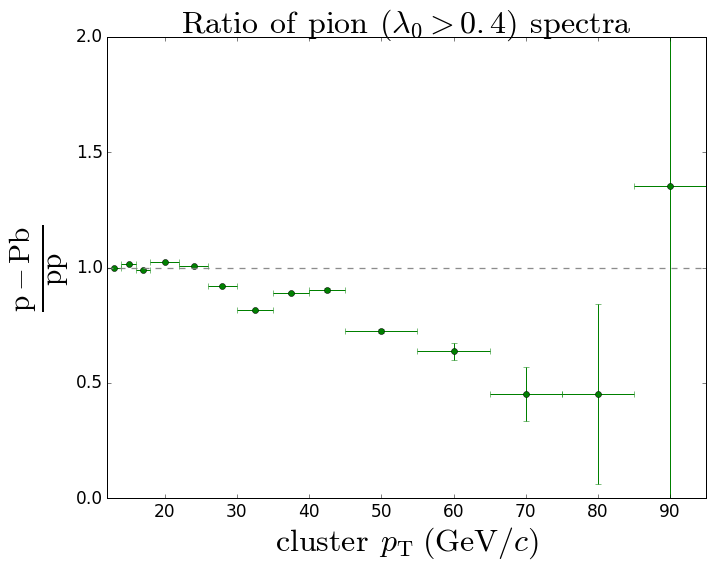

In [13]:
###Make x values with errors###

x_error = np.array([1,1,1,2,2,2,2.5,2.5,2.5,5,5,5,5,5])

x_values = np.array([13,15,17,20,24,28,32.5,37.5,42.5,50,60,70,80,90])

###############################

###Plot the distribution###

fig = plt.figure(figsize=(10,8))

plt.errorbar(x_values,Pion_pt_ratio,xerr=x_error,yerr=ratio_error,fmt='go')

plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \;(\mathrm{GeV}/c)$',fontsize = 32)
plt.xlim((12,95))
plt.xticks(fontsize = 17)
plt.ylabel(r'$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$',fontsize = 42)
plt.yticks(np.arange(0, 2.1, 0.5),fontsize = 17)
plt.ylim((0,2))
plt.legend(prop={'size':20},frameon=False)

plt.axhline(y=1.0,color='gray',linestyle='--',linewidth=1.3,alpha=0.9)

plt.title(r'$\mathrm{Ratio \:\: of \:\: pion \:\: (\lambda_{0} > 0.4) \:\: spectra}$',fontsize=32)

###########################

fig.tight_layout()
plt.show()

In [14]:
def applyCutsNoLambda(fullDataframe,name='default'):  
    
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e',inplace=True)
    fullDataframe.eval('cluster_iso_its_04_sub = cluster_iso_its_04 + cluster_iso_its_04_ue - ue_estimate_its_const*0.4*0.4*3.1416',inplace=True)
    
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'cluster_pt > 12.0',            '12 GeV < pt:')
    dataframe = applyCut(dataframe, 'abs(cluster_eta) < 0.67',      '|eta| < 0.67:')
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e > 0.03', 'ecross/e > 0.03:')
    dataframe = applyCut(dataframe, 'cluster_ncell > 2',            'number of cells > 2')
    dataframe = applyCut(dataframe, 'abs(cluster_tof) < 20',        '|tof| < 20:')
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima < 3',    'maxima < 3:')
    dataframe = applyCut(dataframe, 'cluster_iso_its_04_sub < 1.5', 'Number with ISO pt in its < 1.5 GeV:')
#     dataframe = applyCut(dataframe, 'cluster_Lambda > 0.4',         'Lambda > 0.4:')
    
    return dataframe

In [15]:
print 'p-Pb Data'
pPbHists_04_NL = applyCutsNoLambda(pPbHist_04)
print '\n'
print 'pp Data'
ppHists_04_NL  = applyCutsNoLambda(ppHist_04)

p-Pb Data
12 GeV < pt: 727953  fraction kept: 21.2
|eta| < 0.67: 727617  fraction kept: 100.0
ecross/e > 0.03: 625431  fraction kept: 86.0
number of cells > 2 624977  fraction kept: 99.9
|tof| < 20: 620964  fraction kept: 99.4
maxima < 3: 435925  fraction kept: 70.2
Number with ISO pt in its < 1.5 GeV: 134513  fraction kept: 30.9


pp Data
12 GeV < pt: 415247  fraction kept: 22.2
|eta| < 0.67: 415176  fraction kept: 100.0
ecross/e > 0.03: 347164  fraction kept: 83.6
number of cells > 2 343473  fraction kept: 98.9
|tof| < 20: 253378  fraction kept: 73.8
maxima < 3: 175814  fraction kept: 69.4
Number with ISO pt in its < 1.5 GeV: 60085  fraction kept: 34.2


In [16]:
#####Split it into different pt bins with no Lambda cut#####

###p-Pb###

pPbHists_04_pt_13_NL  = pPbHists_04_NL.query('cluster_pt > 12 and  cluster_pt < 14')
pPbHists_04_pt_15_NL  = pPbHists_04_NL.query('cluster_pt > 14 and  cluster_pt < 16')
pPbHists_04_pt_17_NL  = pPbHists_04_NL.query('cluster_pt > 16 and  cluster_pt < 18')

pPbHists_04_pt_20_NL  = pPbHists_04_NL.query('cluster_pt > 18 and  cluster_pt < 22')
pPbHists_04_pt_24_NL  = pPbHists_04_NL.query('cluster_pt > 22 and  cluster_pt < 26')
pPbHists_04_pt_28_NL  = pPbHists_04_NL.query('cluster_pt > 26 and  cluster_pt < 30')

pPbHists_04_pt_325_NL  = pPbHists_04_NL.query('cluster_pt > 30 and  cluster_pt < 35')
pPbHists_04_pt_375_NL  = pPbHists_04_NL.query('cluster_pt > 35 and  cluster_pt < 40')
pPbHists_04_pt_425_NL  = pPbHists_04_NL.query('cluster_pt > 40 and  cluster_pt < 45')

pPbHists_04_pt_50_NL  = pPbHists_04_NL.query('cluster_pt > 45 and  cluster_pt < 55')
pPbHists_04_pt_60_NL  = pPbHists_04_NL.query('cluster_pt > 55 and  cluster_pt < 65')
pPbHists_04_pt_70_NL  = pPbHists_04_NL.query('cluster_pt > 65 and  cluster_pt < 75')
pPbHists_04_pt_80_NL  = pPbHists_04_NL.query('cluster_pt > 75 and  cluster_pt < 85')
pPbHists_04_pt_90_NL  = pPbHists_04_NL.query('cluster_pt > 85 and  cluster_pt < 95')

pPbHists_04_N_NL = np.array([pPbHists_04_pt_13_NL.shape[0],pPbHists_04_pt_15_NL.shape[0],pPbHists_04_pt_17_NL.shape[0],pPbHists_04_pt_20_NL.shape[0],pPbHists_04_pt_24_NL.shape[0],pPbHists_04_pt_28_NL.shape[0],pPbHists_04_pt_325_NL.shape[0],
                             pPbHists_04_pt_375_NL.shape[0],pPbHists_04_pt_425_NL.shape[0],pPbHists_04_pt_50_NL.shape[0],pPbHists_04_pt_60_NL.shape[0],pPbHists_04_pt_70_NL.shape[0],pPbHists_04_pt_80_NL.shape[0],pPbHists_04_pt_90_NL.shape[0]])

pPbHists_04_tot_NL = float(np.sum(pPbHists_04_N_NL))

pPbHist_04_N_NL = np.divide(pPbHists_04_N_NL,pPbHists_04_tot_NL)

###pp###

ppHists_04_pt_13_NL  = ppHists_04_NL.query('cluster_pt > 12 and  cluster_pt < 14')
ppHists_04_pt_15_NL  = ppHists_04_NL.query('cluster_pt > 14 and  cluster_pt < 16')
ppHists_04_pt_17_NL  = ppHists_04_NL.query('cluster_pt > 16 and  cluster_pt < 18')

ppHists_04_pt_20_NL  = ppHists_04_NL.query('cluster_pt > 18 and  cluster_pt < 22')
ppHists_04_pt_24_NL  = ppHists_04_NL.query('cluster_pt > 22 and  cluster_pt < 26')
ppHists_04_pt_28_NL  = ppHists_04_NL.query('cluster_pt > 26 and  cluster_pt < 30')

ppHists_04_pt_325_NL  = ppHists_04_NL.query('cluster_pt > 30 and  cluster_pt < 35')
ppHists_04_pt_375_NL  = ppHists_04_NL.query('cluster_pt > 35 and  cluster_pt < 40')
ppHists_04_pt_425_NL  = ppHists_04_NL.query('cluster_pt > 40 and  cluster_pt < 45')

ppHists_04_pt_50_NL  = ppHists_04_NL.query('cluster_pt > 45 and  cluster_pt < 55')
ppHists_04_pt_60_NL  = ppHists_04_NL.query('cluster_pt > 55 and  cluster_pt < 65')
ppHists_04_pt_70_NL  = ppHists_04_NL.query('cluster_pt > 65 and  cluster_pt < 75')
ppHists_04_pt_80_NL  = ppHists_04_NL.query('cluster_pt > 75 and  cluster_pt < 85')
ppHists_04_pt_90_NL  = ppHists_04_NL.query('cluster_pt > 85 and  cluster_pt < 95')

ppHists_04_N_NL = np.array([ppHists_04_pt_13_NL.shape[0],ppHists_04_pt_15_NL.shape[0],ppHists_04_pt_17_NL.shape[0],ppHists_04_pt_20_NL.shape[0],ppHists_04_pt_24_NL.shape[0],ppHists_04_pt_28_NL.shape[0],ppHists_04_pt_325_NL.shape[0],
                            ppHists_04_pt_375_NL.shape[0],ppHists_04_pt_425_NL.shape[0],ppHists_04_pt_50_NL.shape[0],ppHists_04_pt_60_NL.shape[0],ppHists_04_pt_70_NL.shape[0],ppHists_04_pt_80_NL.shape[0],ppHists_04_pt_90_NL.shape[0]])

ppHists_04_tot_NL = float(np.sum(ppHists_04_N_NL))

ppHist_04_N_NL = np.divide(ppHists_04_N_NL,ppHists_04_tot_NL)

###Out of convenience I continue to call it Pion pT, but it is no longer just a pion spectra (the same is done later on)###

Pion_pt_ratio_NL = np.divide(pPbHist_04_N_NL,ppHist_04_N_NL)

In [17]:
pPbHists_04_N_err_NL = np.divide(1,np.sqrt(pPbHists_04_N_NL))

ppHists_04_N_err_NL  = np.divide(1,np.sqrt(ppHists_04_N_NL))

ratio_error_NL = propErrors(ppHists_04_N_NL,pPbHists_04_N_NL,ppHists_04_N_err_NL,pPbHists_04_N_err_NL)*(np.divide(pPbHists_04_tot_NL,ppHists_04_tot_NL))

In [18]:
def applyCutsDiffLambda(fullDataframe,name='default'):  
    
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e',inplace=True)
    fullDataframe.eval('cluster_iso_its_04_sub = cluster_iso_its_04 + cluster_iso_its_04_ue - ue_estimate_its_const*0.4*0.4*3.1416',inplace=True)
    
    dataframe = fullDataframe
    dataframe = applyCut(dataframe, 'cluster_pt > 12.0',            '12 GeV < pt:')
    dataframe = applyCut(dataframe, 'abs(cluster_eta) < 0.67',      '|eta| < 0.67:')
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e > 0.03', 'ecross/e > 0.03:')
    dataframe = applyCut(dataframe, 'cluster_ncell > 2',            'number of cells > 2')
    dataframe = applyCut(dataframe, 'abs(cluster_tof) < 20',        '|tof| < 20:')
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima < 3',    'maxima < 3:')
    dataframe = applyCut(dataframe, 'cluster_iso_its_04_sub < 1.5', 'Number with ISO pt in its < 1.5 GeV:')
    dataframe = applyCut(dataframe, 'cluster_Lambda < 0.4',         'Lambda < 0.4:')
    
    return dataframe

In [19]:
print 'p-Pb Data'
pPbHists_04_DL = applyCutsDiffLambda(pPbHist_04)
print '\n'
print 'pp Data'
ppHists_04_DL  = applyCutsDiffLambda(ppHist_04)

p-Pb Data
12 GeV < pt: 727953  fraction kept: 21.2
|eta| < 0.67: 727617  fraction kept: 100.0
ecross/e > 0.03: 625431  fraction kept: 86.0
number of cells > 2 624977  fraction kept: 99.9
|tof| < 20: 620964  fraction kept: 99.4
maxima < 3: 435925  fraction kept: 70.2
Number with ISO pt in its < 1.5 GeV: 134513  fraction kept: 30.9
Lambda < 0.4: 50033  fraction kept: 37.2


pp Data
12 GeV < pt: 415247  fraction kept: 22.2
|eta| < 0.67: 415176  fraction kept: 100.0
ecross/e > 0.03: 347164  fraction kept: 83.6
number of cells > 2 343473  fraction kept: 98.9
|tof| < 20: 253378  fraction kept: 73.8
maxima < 3: 175814  fraction kept: 69.4
Number with ISO pt in its < 1.5 GeV: 60085  fraction kept: 34.2
Lambda < 0.4: 21913  fraction kept: 36.5


In [20]:
#####Split it into different pt bins with different Lambda cut from before#####

###p-Pb###

pPbHists_04_pt_13_DL  = pPbHists_04_DL.query('cluster_pt > 12 and  cluster_pt < 14')
pPbHists_04_pt_15_DL  = pPbHists_04_DL.query('cluster_pt > 14 and  cluster_pt < 16')
pPbHists_04_pt_17_DL  = pPbHists_04_DL.query('cluster_pt > 16 and  cluster_pt < 18')

pPbHists_04_pt_20_DL  = pPbHists_04_DL.query('cluster_pt > 18 and  cluster_pt < 22')
pPbHists_04_pt_24_DL  = pPbHists_04_DL.query('cluster_pt > 22 and  cluster_pt < 26')
pPbHists_04_pt_28_DL  = pPbHists_04_DL.query('cluster_pt > 26 and  cluster_pt < 30')

pPbHists_04_pt_325_DL  = pPbHists_04_DL.query('cluster_pt > 30 and  cluster_pt < 35')
pPbHists_04_pt_375_DL  = pPbHists_04_DL.query('cluster_pt > 35 and  cluster_pt < 40')
pPbHists_04_pt_425_DL  = pPbHists_04_DL.query('cluster_pt > 40 and  cluster_pt < 45')

pPbHists_04_pt_50_DL  = pPbHists_04_DL.query('cluster_pt > 45 and  cluster_pt < 55')
pPbHists_04_pt_60_DL  = pPbHists_04_DL.query('cluster_pt > 55 and  cluster_pt < 65')
pPbHists_04_pt_70_DL  = pPbHists_04_DL.query('cluster_pt > 65 and  cluster_pt < 75')
pPbHists_04_pt_80_DL  = pPbHists_04_DL.query('cluster_pt > 75 and  cluster_pt < 85')
pPbHists_04_pt_90_DL  = pPbHists_04_DL.query('cluster_pt > 85 and  cluster_pt < 95')

pPbHists_04_N_DL = np.array([pPbHists_04_pt_13_DL.shape[0],pPbHists_04_pt_15_DL.shape[0],pPbHists_04_pt_17_DL.shape[0],pPbHists_04_pt_20_DL.shape[0],pPbHists_04_pt_24_DL.shape[0],pPbHists_04_pt_28_DL.shape[0],pPbHists_04_pt_325_DL.shape[0],
                             pPbHists_04_pt_375_DL.shape[0],pPbHists_04_pt_425_DL.shape[0],pPbHists_04_pt_50_DL.shape[0],pPbHists_04_pt_60_DL.shape[0],pPbHists_04_pt_70_DL.shape[0],pPbHists_04_pt_80_DL.shape[0],pPbHists_04_pt_90_DL.shape[0]])

pPbHists_04_tot_DL = float(np.sum(pPbHists_04_N_DL))

pPbHist_04_N_DL = np.divide(pPbHists_04_N_DL,pPbHists_04_tot_DL)

###pp###

ppHists_04_pt_13_DL  = ppHists_04_DL.query('cluster_pt > 12 and  cluster_pt < 14')
ppHists_04_pt_15_DL  = ppHists_04_DL.query('cluster_pt > 14 and  cluster_pt < 16')
ppHists_04_pt_17_DL  = ppHists_04_DL.query('cluster_pt > 16 and  cluster_pt < 18')

ppHists_04_pt_20_DL  = ppHists_04_DL.query('cluster_pt > 18 and  cluster_pt < 22')
ppHists_04_pt_24_DL  = ppHists_04_DL.query('cluster_pt > 22 and  cluster_pt < 26')
ppHists_04_pt_28_DL  = ppHists_04_DL.query('cluster_pt > 26 and  cluster_pt < 30')

ppHists_04_pt_325_DL  = ppHists_04_DL.query('cluster_pt > 30 and  cluster_pt < 35')
ppHists_04_pt_375_DL  = ppHists_04_DL.query('cluster_pt > 35 and  cluster_pt < 40')
ppHists_04_pt_425_DL  = ppHists_04_DL.query('cluster_pt > 40 and  cluster_pt < 45')

ppHists_04_pt_50_DL  = ppHists_04_DL.query('cluster_pt > 45 and  cluster_pt < 55')
ppHists_04_pt_60_DL  = ppHists_04_DL.query('cluster_pt > 55 and  cluster_pt < 65')
ppHists_04_pt_70_DL  = ppHists_04_DL.query('cluster_pt > 65 and  cluster_pt < 75')
ppHists_04_pt_80_DL  = ppHists_04_DL.query('cluster_pt > 75 and  cluster_pt < 85')
ppHists_04_pt_90_DL  = ppHists_04_DL.query('cluster_pt > 85 and  cluster_pt < 95')

ppHists_04_N_DL = np.array([ppHists_04_pt_13_DL.shape[0],ppHists_04_pt_15_DL.shape[0],ppHists_04_pt_17_DL.shape[0],ppHists_04_pt_20_DL.shape[0],ppHists_04_pt_24_DL.shape[0],ppHists_04_pt_28_DL.shape[0],ppHists_04_pt_325_DL.shape[0],
                            ppHists_04_pt_375_DL.shape[0],ppHists_04_pt_425_DL.shape[0],ppHists_04_pt_50_DL.shape[0],ppHists_04_pt_60_DL.shape[0],ppHists_04_pt_70_DL.shape[0],ppHists_04_pt_80_DL.shape[0],ppHists_04_pt_90_DL.shape[0]])

ppHists_04_tot_DL = float(np.sum(ppHists_04_N_DL))

ppHist_04_N_DL = np.divide(ppHists_04_N_DL,ppHists_04_tot_DL)


Pion_pt_ratio_DL = np.divide(pPbHist_04_N_DL,ppHist_04_N_DL)

In [21]:
pPbHists_04_N_err_DL = np.divide(1,np.sqrt(pPbHists_04_N_DL))

ppHists_04_N_err_DL  = np.divide(1,np.sqrt(ppHists_04_N_DL))

ratio_error_DL = propErrors(ppHists_04_N_DL,pPbHists_04_N_DL,ppHists_04_N_err_DL,pPbHists_04_N_err_DL)*(np.divide(pPbHists_04_tot_DL,ppHists_04_tot_DL))

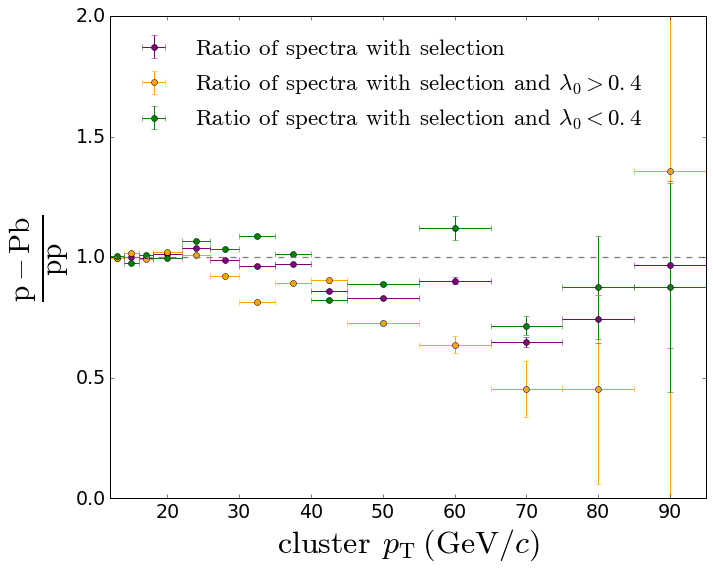

In [24]:
###Plot the distribution###

fig = plt.figure(figsize=(10,8))

plt.errorbar(x_values,Pion_pt_ratio_NL,xerr=x_error,yerr=ratio_error_NL,fmt='o',color='purple',label=r'$\mathrm{Ratio \:\: of \:\: spectra \:\: with \:\: selection}$')
plt.errorbar(x_values,Pion_pt_ratio,xerr=x_error,yerr=ratio_error,fmt='o',color='orange',label=r'$\mathrm{Ratio \:\: of \:\: spectra\:\: with \:\: selection \:\: and \:\: \lambda_{0} > 0.4}$')
plt.errorbar(x_values,Pion_pt_ratio_DL,xerr=x_error,yerr=ratio_error_DL,fmt='go',label=r'$\mathrm{Ratio \:\: of \:\: spectra\:\: with \:\: selection \:\: and \:\: \lambda_{0} < 0.4}$')

plt.xlabel(r'$\mathrm{cluster} \:\: p_\mathrm{T} \:(\mathrm{GeV}/c)$',fontsize = 32)
plt.xlim((12,95))
plt.xticks(fontsize = 19)
plt.ylabel(r'$\frac{\mathrm{p-Pb}}{\mathrm{pp}}$',fontsize = 42)
plt.yticks(np.arange(0, 2.1, 0.5),fontsize = 19)
plt.ylim((0,2))
plt.legend(prop={'size':23},frameon=False,numpoints=1,loc='upper left')

plt.axhline(y=1.0,color='gray',linestyle='--',linewidth=1.3)

# plt.title(r'$\mathrm{Ratio \:\: of \:\: spectra}$',fontsize=32)

###########################

fig.tight_layout()
plt.show()